In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
%matplotlib inline

In [2]:
train = pd.read_csv('playground-series-s3e19/train.csv', index_col='id')
train['date'] = pd.to_datetime(train['date'])
train

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...
136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111


In [3]:
test = pd.read_csv('playground-series-s3e19/test.csv', index_col='id')
test['date'] = pd.to_datetime(test['date'])
test

,date,country,store,product
id,,,,
136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better
...,...,...,...,...
164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding
164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs
164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People


## Аналитика

Пропусков в данных нет

In [4]:
print(train.isna().sum(), test.isna().sum(), sep='\n\n')

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

date       0
country    0
store      0
product    0
dtype: int64


Нет дисбаланса классов

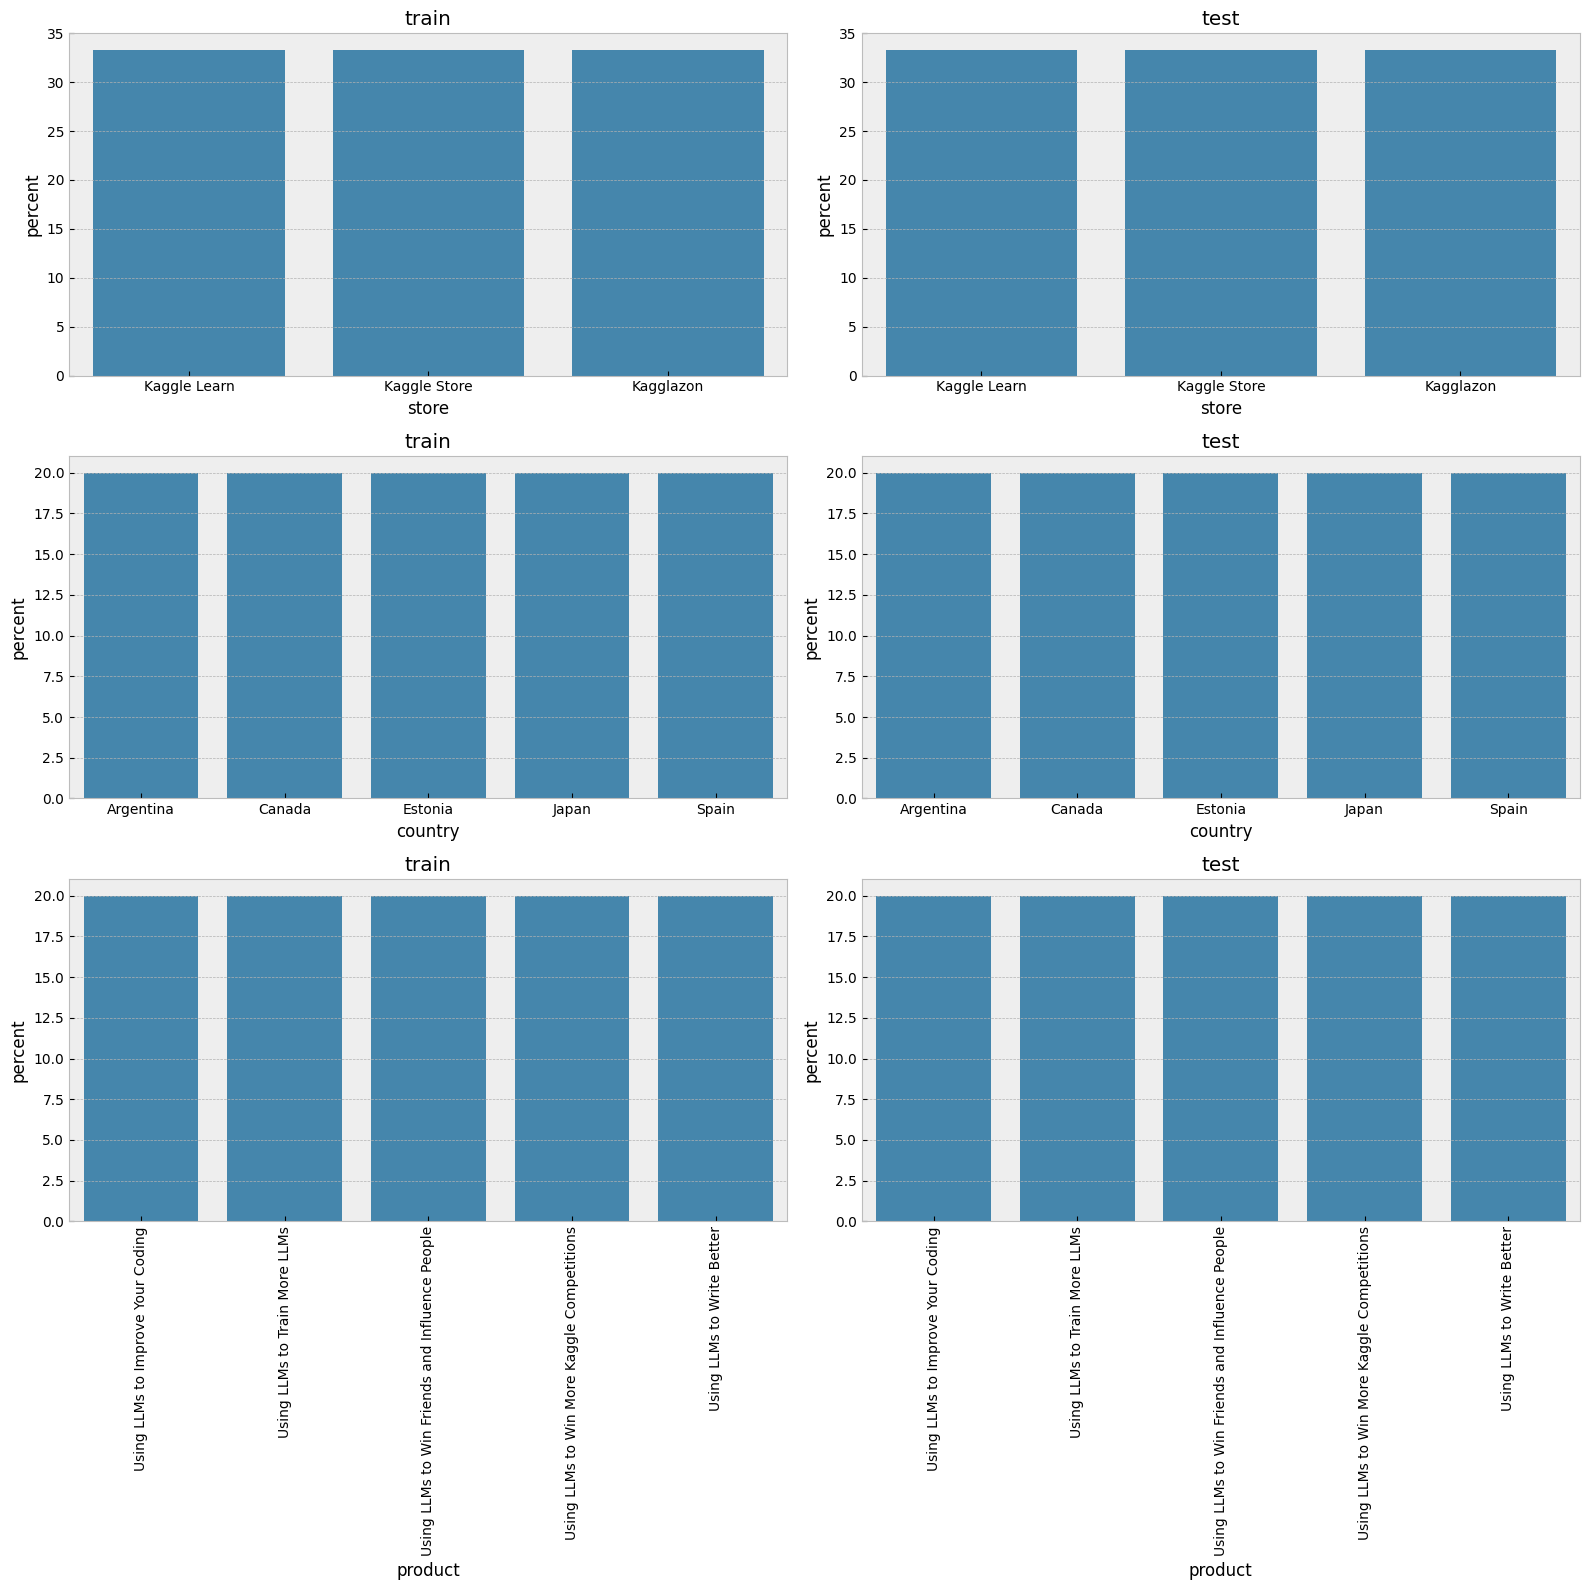

In [5]:
COLUMNS = ['store', 'country', 'product']
DATASETS = {
    'train': train,
    'test': test,
}

plt.figure(figsize=(16, 16))

for i, col in enumerate(COLUMNS):
    for j, row in enumerate(DATASETS, 1):
        plt.subplot(len(COLUMNS), len(DATASETS), i * len(DATASETS) + j)

        plt.title(row)
        sns.countplot(data=DATASETS[row], x=col, stat='percent')
        if col == 'product':
            plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

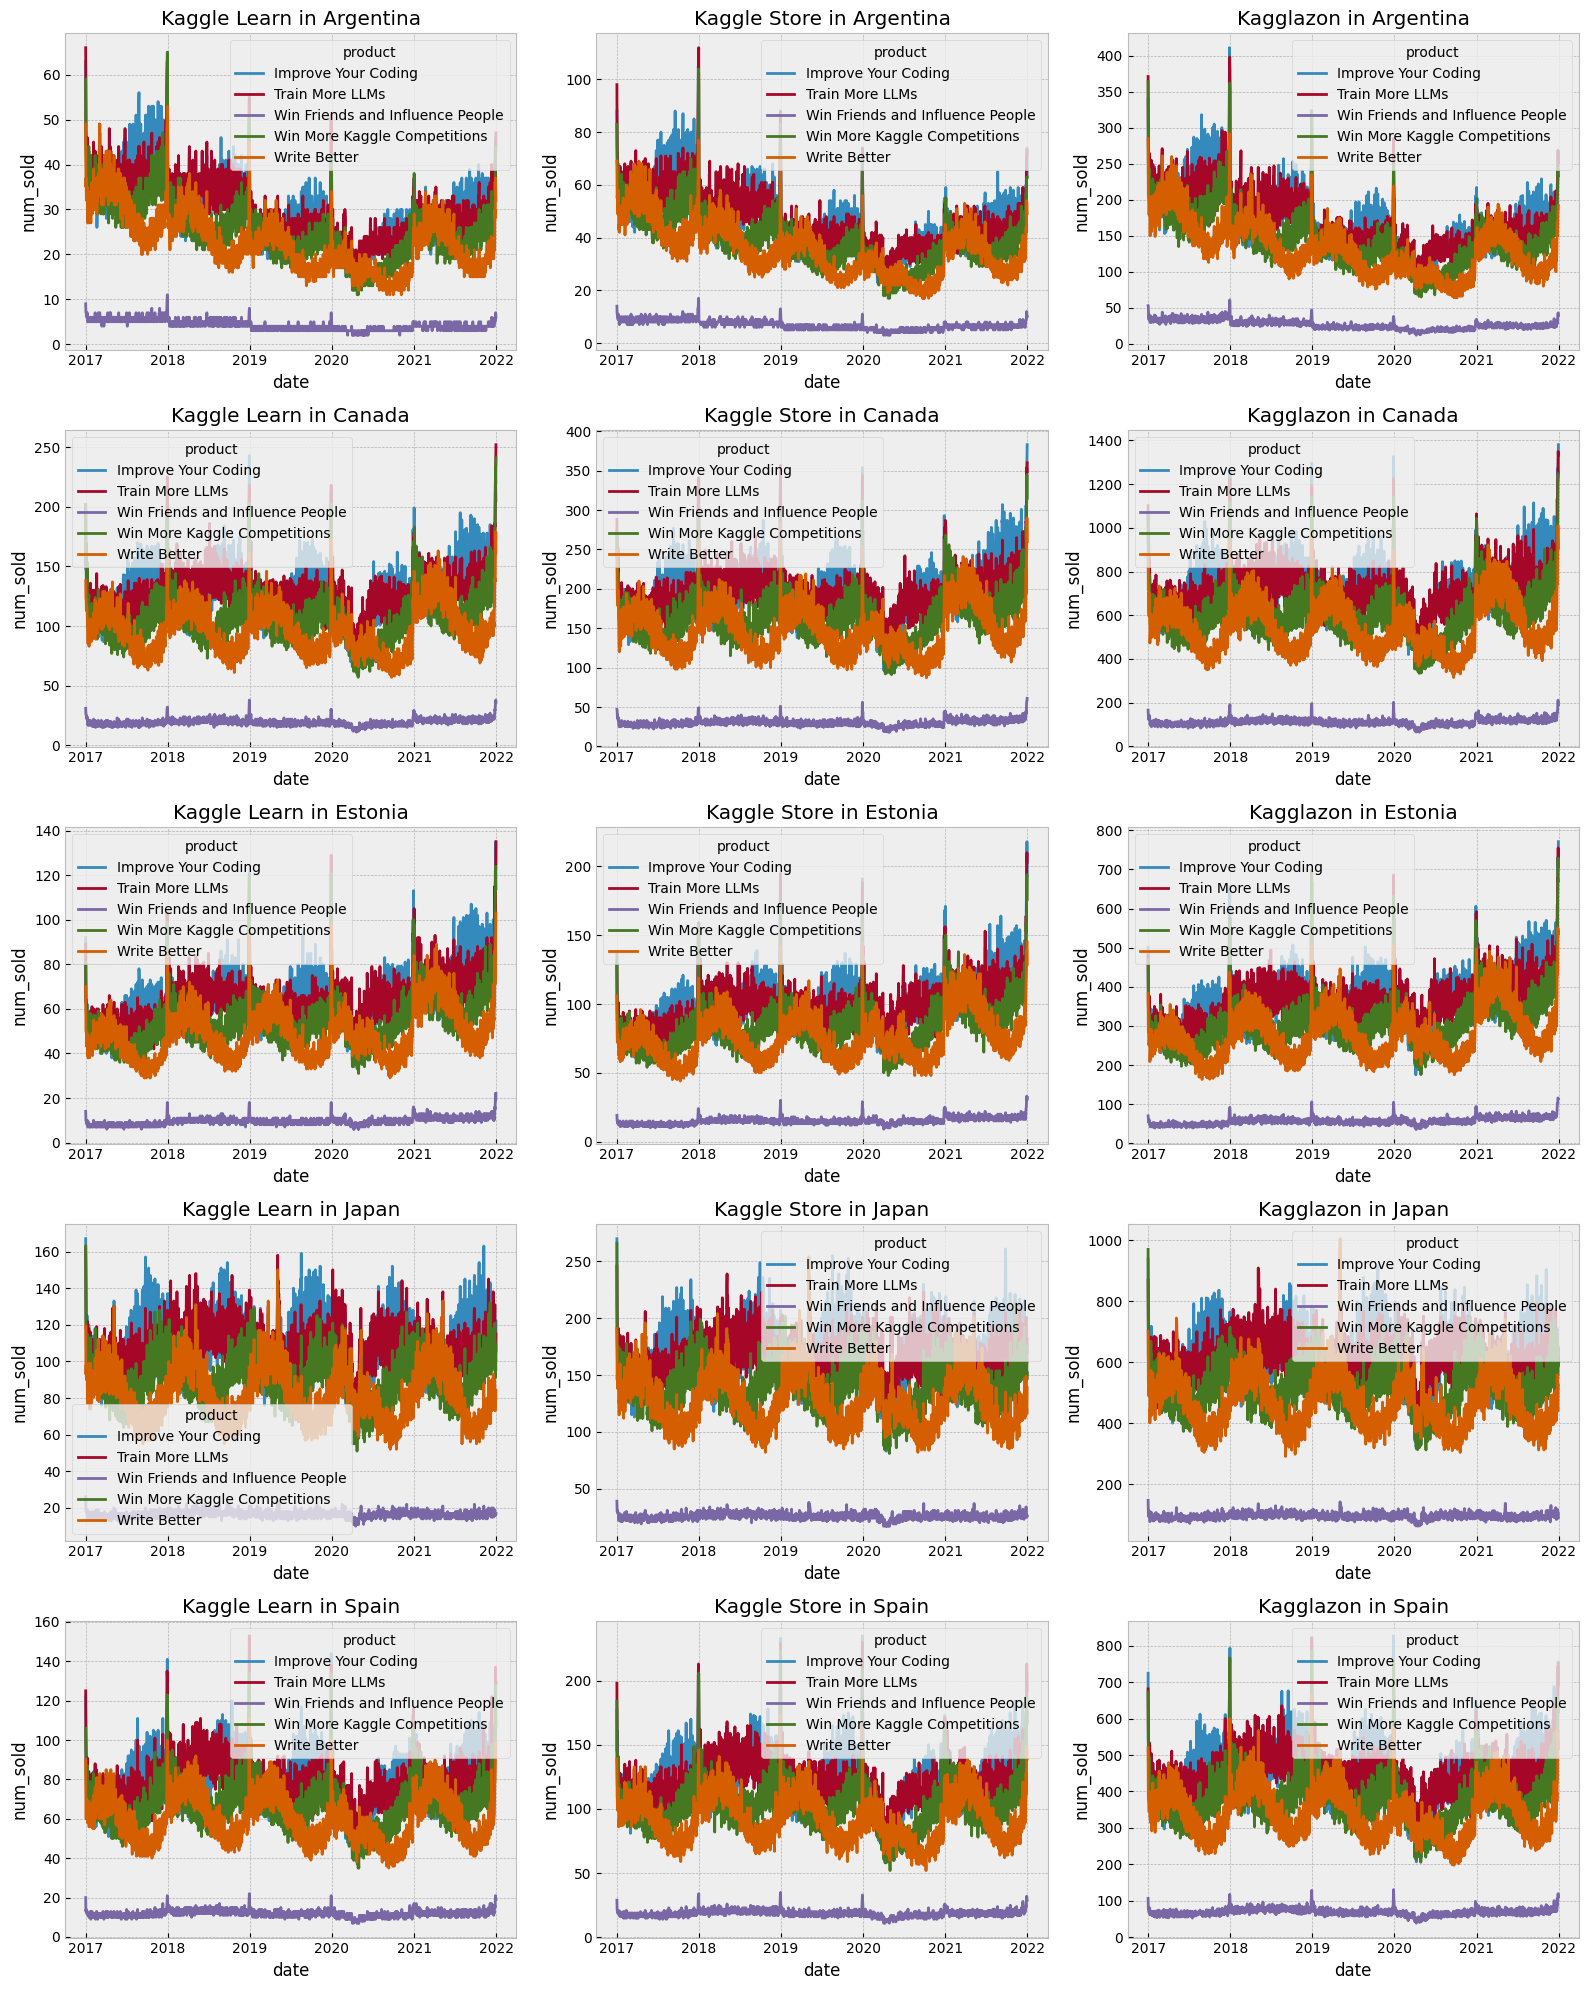

In [6]:
import warnings
warnings.filterwarnings("ignore")


COUNTRIES = train['country'].unique()
STORES = train['store'].unique()

plt.figure(figsize=(16, 20))

for i, country in enumerate(COUNTRIES):
    for j, store in enumerate(STORES, 1):
        plt.subplot(len(COUNTRIES), len(STORES), i * len(STORES) + j)

        plt.title(f'{store} in {country}')
        sl = train[(train['country'] == country) & (train['store'] == store)]
        sl['product'] = sl['product'].str.removeprefix('Using LLMs to ')
        sns.lineplot(data=sl, x='date', y='num_sold', hue='product')

plt.tight_layout()
plt.show()

- В начале каждого кода по всем продуктам видим большие выбросы, но их немного, а потому можно игнорировать.
- Каждый продукт продается лучше всего в свое время года. Причем поведение похоже на синусоиду. Некоторые с периодом в год, некоторые с периодом в 2 года.
- Выбивается 2020 год из общей картины по причине пандемии.

## Добавим фичи

In [7]:
def extract_features(df: pd.DataFrame):
    df = df.copy()
    # фича неизвестна на тесте
    # df['year'] = df['date'].dt.year
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df.drop('date', axis='columns', inplace=True)

    return df

train_feat = extract_features(train)

target = 'num_sold'
features = [col for col in train_feat.columns if col != target]

In [8]:
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(train_feat[features], train_feat[target], test_size=0.25, shuffle=False, random_state=42)

In [9]:
from catboost import CatBoostRegressor


model = CatBoostRegressor(iterations=1500, max_depth=5)
model.fit(x_train, y_train, cat_features=features, eval_set=(x_val, y_val), early_stopping_rounds=100)

Learning rate set to 0.082282
0:	learn: 165.7390783	test: 182.4572079	best: 182.4572079 (0)	total: 75.3ms	remaining: 1m 52s
1:	learn: 153.5502944	test: 170.7129336	best: 170.7129336 (1)	total: 86.6ms	remaining: 1m 4s
2:	learn: 142.3112084	test: 159.5093208	best: 159.5093208 (2)	total: 94ms	remaining: 46.9s
3:	learn: 132.2972653	test: 149.9404639	best: 149.9404639 (3)	total: 101ms	remaining: 37.7s
4:	learn: 122.8021330	test: 140.4868547	best: 140.4868547 (4)	total: 108ms	remaining: 32.2s
5:	learn: 114.1954994	test: 131.9068925	best: 131.9068925 (5)	total: 118ms	remaining: 29.4s
6:	learn: 106.4371935	test: 124.1610007	best: 124.1610007 (6)	total: 125ms	remaining: 26.7s
7:	learn: 99.4507415	test: 117.2319905	best: 117.2319905 (7)	total: 132ms	remaining: 24.6s
8:	learn: 93.0465557	test: 110.8079764	best: 110.8079764 (8)	total: 139ms	remaining: 23s
9:	learn: 87.3431969	test: 105.2502529	best: 105.2502529 (9)	total: 146ms	remaining: 21.8s
10:	learn: 82.1425185	test: 100.0438955	best: 100.043

In [10]:
from sklearn.metrics import mean_absolute_percentage_error


def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F) + 1e-20)
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100


preds = model.predict(x_val)
print(f'MAPE = {mean_absolute_percentage_error(y_val, preds):.3f}')
print(f'SMAPE = {smape(y_val, preds):.3f}')

MAPE = 0.134
SMAPE = 13.710


In [11]:
no_val_model = CatBoostRegressor(iterations=600, max_depth=5)
no_val_model.fit(train_feat[features], train_feat[target], cat_features=features)

Learning rate set to 0.134933
0:	learn: 160.8619585	total: 13.9ms	remaining: 8.33s
1:	learn: 141.3808482	total: 25.3ms	remaining: 7.57s
2:	learn: 124.8255968	total: 33.7ms	remaining: 6.71s
3:	learn: 110.9189299	total: 42ms	remaining: 6.25s
4:	learn: 98.8597068	total: 50.4ms	remaining: 6s
5:	learn: 88.8110221	total: 58.7ms	remaining: 5.81s
6:	learn: 80.2881872	total: 67ms	remaining: 5.68s
7:	learn: 73.2844368	total: 75.4ms	remaining: 5.58s
8:	learn: 67.3343744	total: 86.4ms	remaining: 5.67s
9:	learn: 62.5442454	total: 94.5ms	remaining: 5.58s
10:	learn: 58.5532039	total: 103ms	remaining: 5.49s
11:	learn: 55.0576093	total: 112ms	remaining: 5.47s
12:	learn: 52.2154894	total: 120ms	remaining: 5.43s
13:	learn: 49.8175012	total: 129ms	remaining: 5.42s
14:	learn: 47.7587255	total: 141ms	remaining: 5.5s
15:	learn: 45.4589664	total: 152ms	remaining: 5.55s
16:	learn: 43.7719290	total: 166ms	remaining: 5.69s
17:	learn: 42.3267448	total: 177ms	remaining: 5.73s
18:	learn: 41.1653381	total: 187ms	rem

In [12]:
submission = pd.DataFrame(
    {
        'id': test.index,
        'num_sold': no_val_model.predict(extract_features(test)).astype(np.int32),
    }
)

submission.to_csv('playground-series-s3e19/first_submission.csv', index=None)
submission

,id,num_sold
0,136950,30
1,136951,30
2,136952,0
3,136953,27
4,136954,24
...,...,...
27370,164320,626
27371,164321,584
27372,164322,122
27373,164323,566


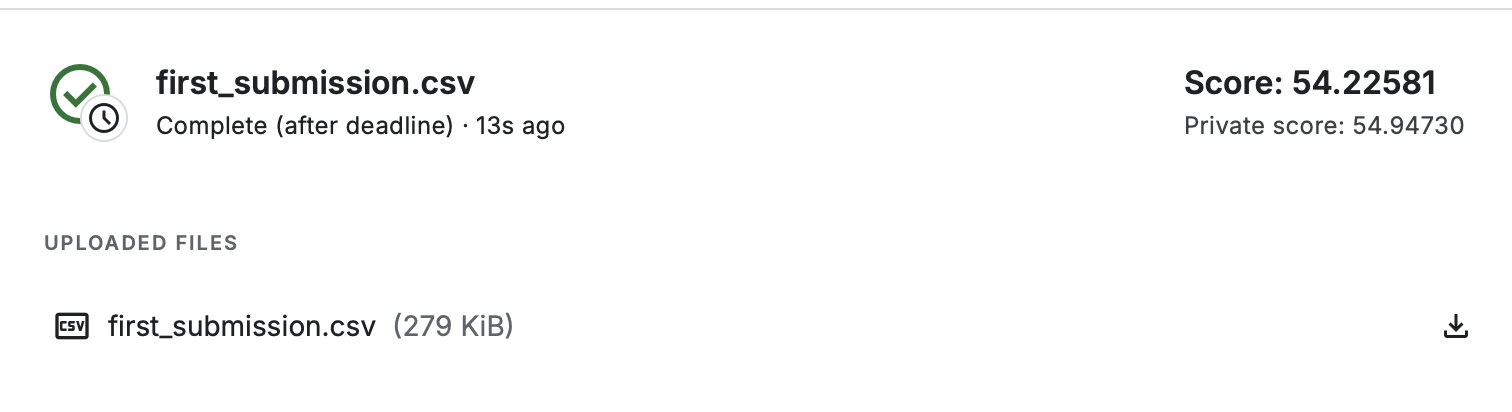

In [13]:
from IPython.display import Image


Image(filename='playground-series-s3e19/first_submission.png') 

Посмотрим на предсказания

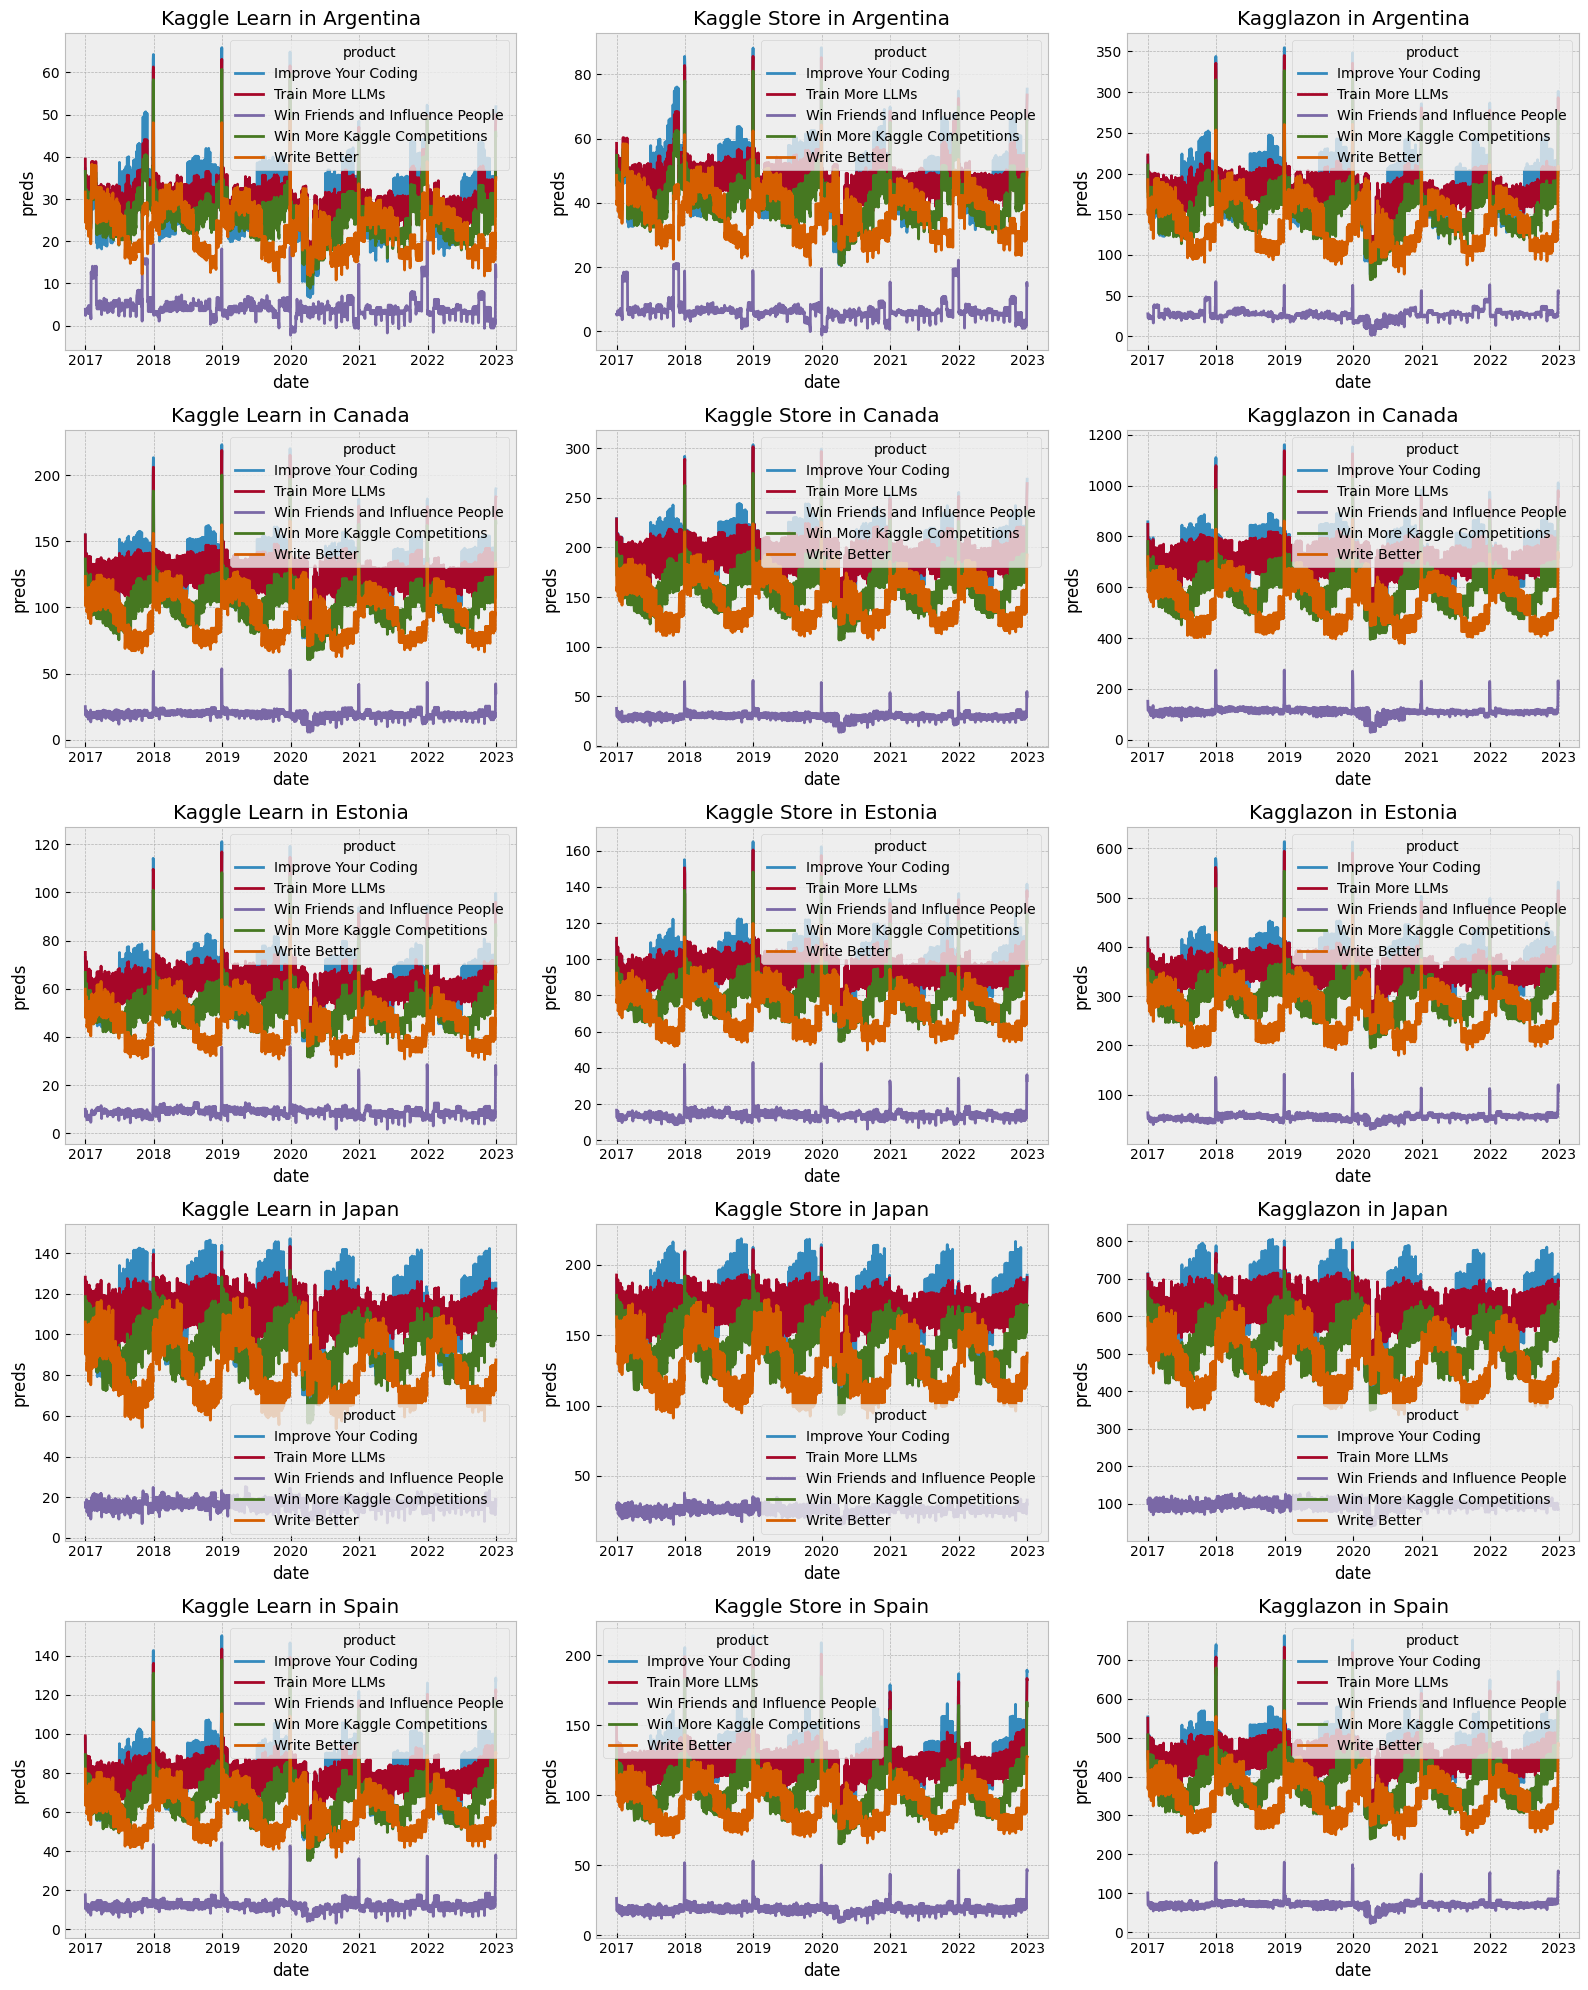

In [14]:
plt.figure(figsize=(16, 20))


df = pd.concat([train, test], axis='rows').fillna(0)
df['preds'] = model.predict(extract_features(df)[features])

for i, country in enumerate(COUNTRIES):
    for j, store in enumerate(STORES, 1):
        plt.subplot(len(COUNTRIES), len(STORES), i * len(STORES) + j)

        plt.title(f'{store} in {country}')
        sl = df[(df['country'] == country) & (df['store'] == store)]
        sl['product'] = sl['product'].str.removeprefix('Using LLMs to ')
        sns.lineplot(data=sl, x='date', y='preds', hue='product')

plt.tight_layout()
plt.show()

## Улучшения

У градиентного бустинга довольно плохо получилось предсказать гладкую кривую общего тренда.
Также есть проблемы с тенденцией на протяжении нескольких лет, так как не получается добавить этот категориальный признак из-за обучения.

Таким образом нужна модель, которая сможет хорошо предсказать гладкие кривые и аппроксимировать поведение в будущий год. Для этого должна подойти линейная модель.

Ошибка распределена не нормально, а скорее по Лапласу.
По этой причине стоит логарифмировать таргер.

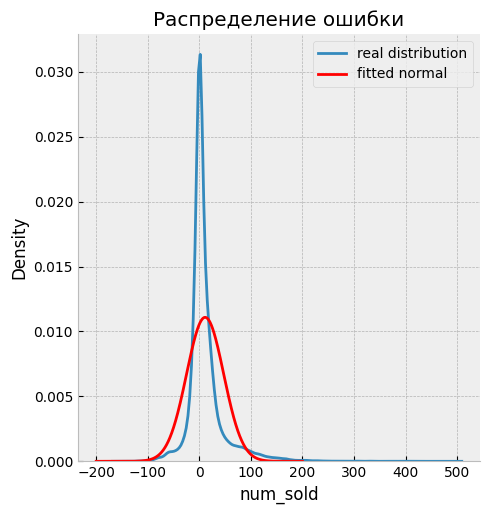

In [15]:
from scipy.stats import norm


error = y_val - model.predict(x_val)
mu, std = norm.fit(error)
sns.displot(error, kind='kde', label='real distribution')
x = np.linspace(-200, 200, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, label='fitted normal', color='red')
plt.title('Распределение ошибки')
plt.legend()
plt.show()

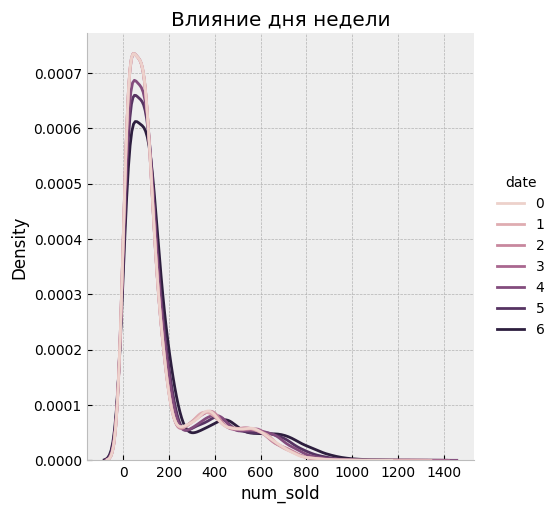

In [16]:
sns.displot(train, x='num_sold', hue=train['date'].dt.weekday, kind='kde')
plt.title('Влияние дня недели')
plt.show()

- Добавим праздники, так как если влияет день недели, то и праздники
- Также можно видеть сильный скачек в новый год, стоит добавить признаки этого.
- Добавим год и признаки 2020 года, чтобы не смещать модель на эпидемию
- Добавить нелинейность в год, так как среднее некоторых продуктов идет по кривой, а не прямой
- Добавим sin и cos с нужными периодами, чтобы учесть поведение продаж каждого продукта

In [17]:
import datetime as dt
import holidays


PRODUCTS = train['product'].unique()


def better_extract_features(df: pd.DataFrame):
    df = df.copy()
    # time features
    df['year'] = df['date'].dt.year
    t = (df['date'] - df['date'].min()) / dt.timedelta(days=1)
    df['year_sq'] = (df['year'] - df['year'].min())**2
    df['year_cubed'] = (df['year'] - df['year'].min())**3

    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday

    # 2020 features
    df['is_2020'] = (df['date'].dt.year == 2020).astype(float)
    for month in range(1, 12 + 1):
        df[f'2020_month_{month}'] = (df['month'] == month) * df['is_2020']

    # cyclic features
    cyclic = ['sin_yearly', 'sin_yearly_2', 'cos_yearly', 'cos_yearly_2']
    df['sin_yearly'] = np.sin(2 * np.pi * t / 365)
    df['sin_yearly_2'] = np.sin(2 * np.pi * t / (2 * 365))
    df['cos_yearly'] = np.cos(2 * np.pi * t / 365)
    df['cos_yearly_2'] = np.cos(2 * np.pi * t / (2 * 365))

    for product in PRODUCTS[:-1]:
        for feat in cyclic:
            df[f'{feat}_{product}'] = df[feat] * (df['product'] == product)

    # holiday
    for country in COUNTRIES:
        hol = holidays.country_holidays(country)
        idxs = (df['country'] == country)
        for delta in range(-7, 8):
            df.loc[idxs, 'holiday'] = df.loc[idxs, 'date'].apply(lambda d: (d - dt.timedelta(days=delta)) in hol).astype(float)

    # new year
    for delta in range(-5, 11):
        shifted = df['date'] - dt.timedelta(days=delta)
        df[f'new_year_{delta}'] = ((shifted.dt.month == 1) & (shifted.dt.day == 1)).astype(float)

    # one hot encoding
    df = pd.get_dummies(
        df,
        columns=[
            'day',
            'month',
            'weekday',
            'store',
            'product',
            'country'
        ],
        drop_first=True,
    )

    return df

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


train_better_feat = better_extract_features(train)

target = 'num_sold'
exclude_lin = [
    'country',
    'product',
    'store',
    'date',
    target,
] + ['sin_yearly', 'sin_yearly_2', 'cos_yearly', 'cos_yearly_2']
features = [col for col in train_better_feat if col not in exclude_lin]

x_train, x_val, y_train, y_val = train_test_split(train_better_feat[features], np.log(train_better_feat[target]), test_size=0.15, shuffle=False, random_state=42)
scaler = StandardScaler().fit(x_train)

In [19]:
lin_model = Ridge(alpha=10).fit(scaler.transform(x_train), y_train)
preds = np.exp(lin_model.predict(scaler.transform(x_train))).round().astype(np.int32)

print(f'MAPE = {mean_absolute_percentage_error(np.exp(y_train), preds):.3f}')
print(f'SMAPE = {smape(np.exp(y_train), preds):.3f}')

preds = np.exp(lin_model.predict(scaler.transform(x_val))).round().astype(np.int32)

print(f'MAPE = {mean_absolute_percentage_error(np.exp(y_val), preds):.3f}')
print(f'SMAPE = {smape(np.exp(y_val), preds):.3f}')

MAPE = 0.085
SMAPE = 8.446
MAPE = 0.092
SMAPE = 9.188


In [20]:
test_better_feat = better_extract_features(test)

In [21]:
preds = np.exp(lin_model.predict(scaler.transform(test_better_feat[features]))).round().astype(np.int32)

submission = pd.DataFrame(
    {
        'id': test.index,
        'num_sold': preds,
    }
)

submission.to_csv('playground-series-s3e19/second_submission.csv', index=None)
submission

,id,num_sold
0,136950,52
1,136951,51
2,136952,8
3,136953,49
4,136954,39
...,...,...
27370,164320,825
27371,164321,832
27372,164322,127
27373,164323,776


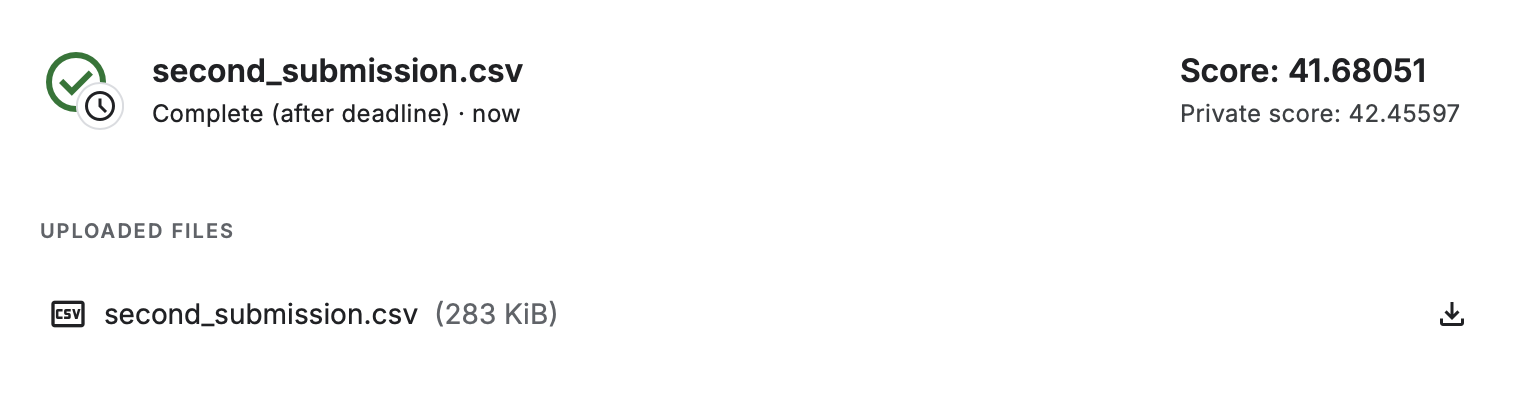

In [41]:
from IPython.display import Image


Image(filename='playground-series-s3e19/second_submission.png') 

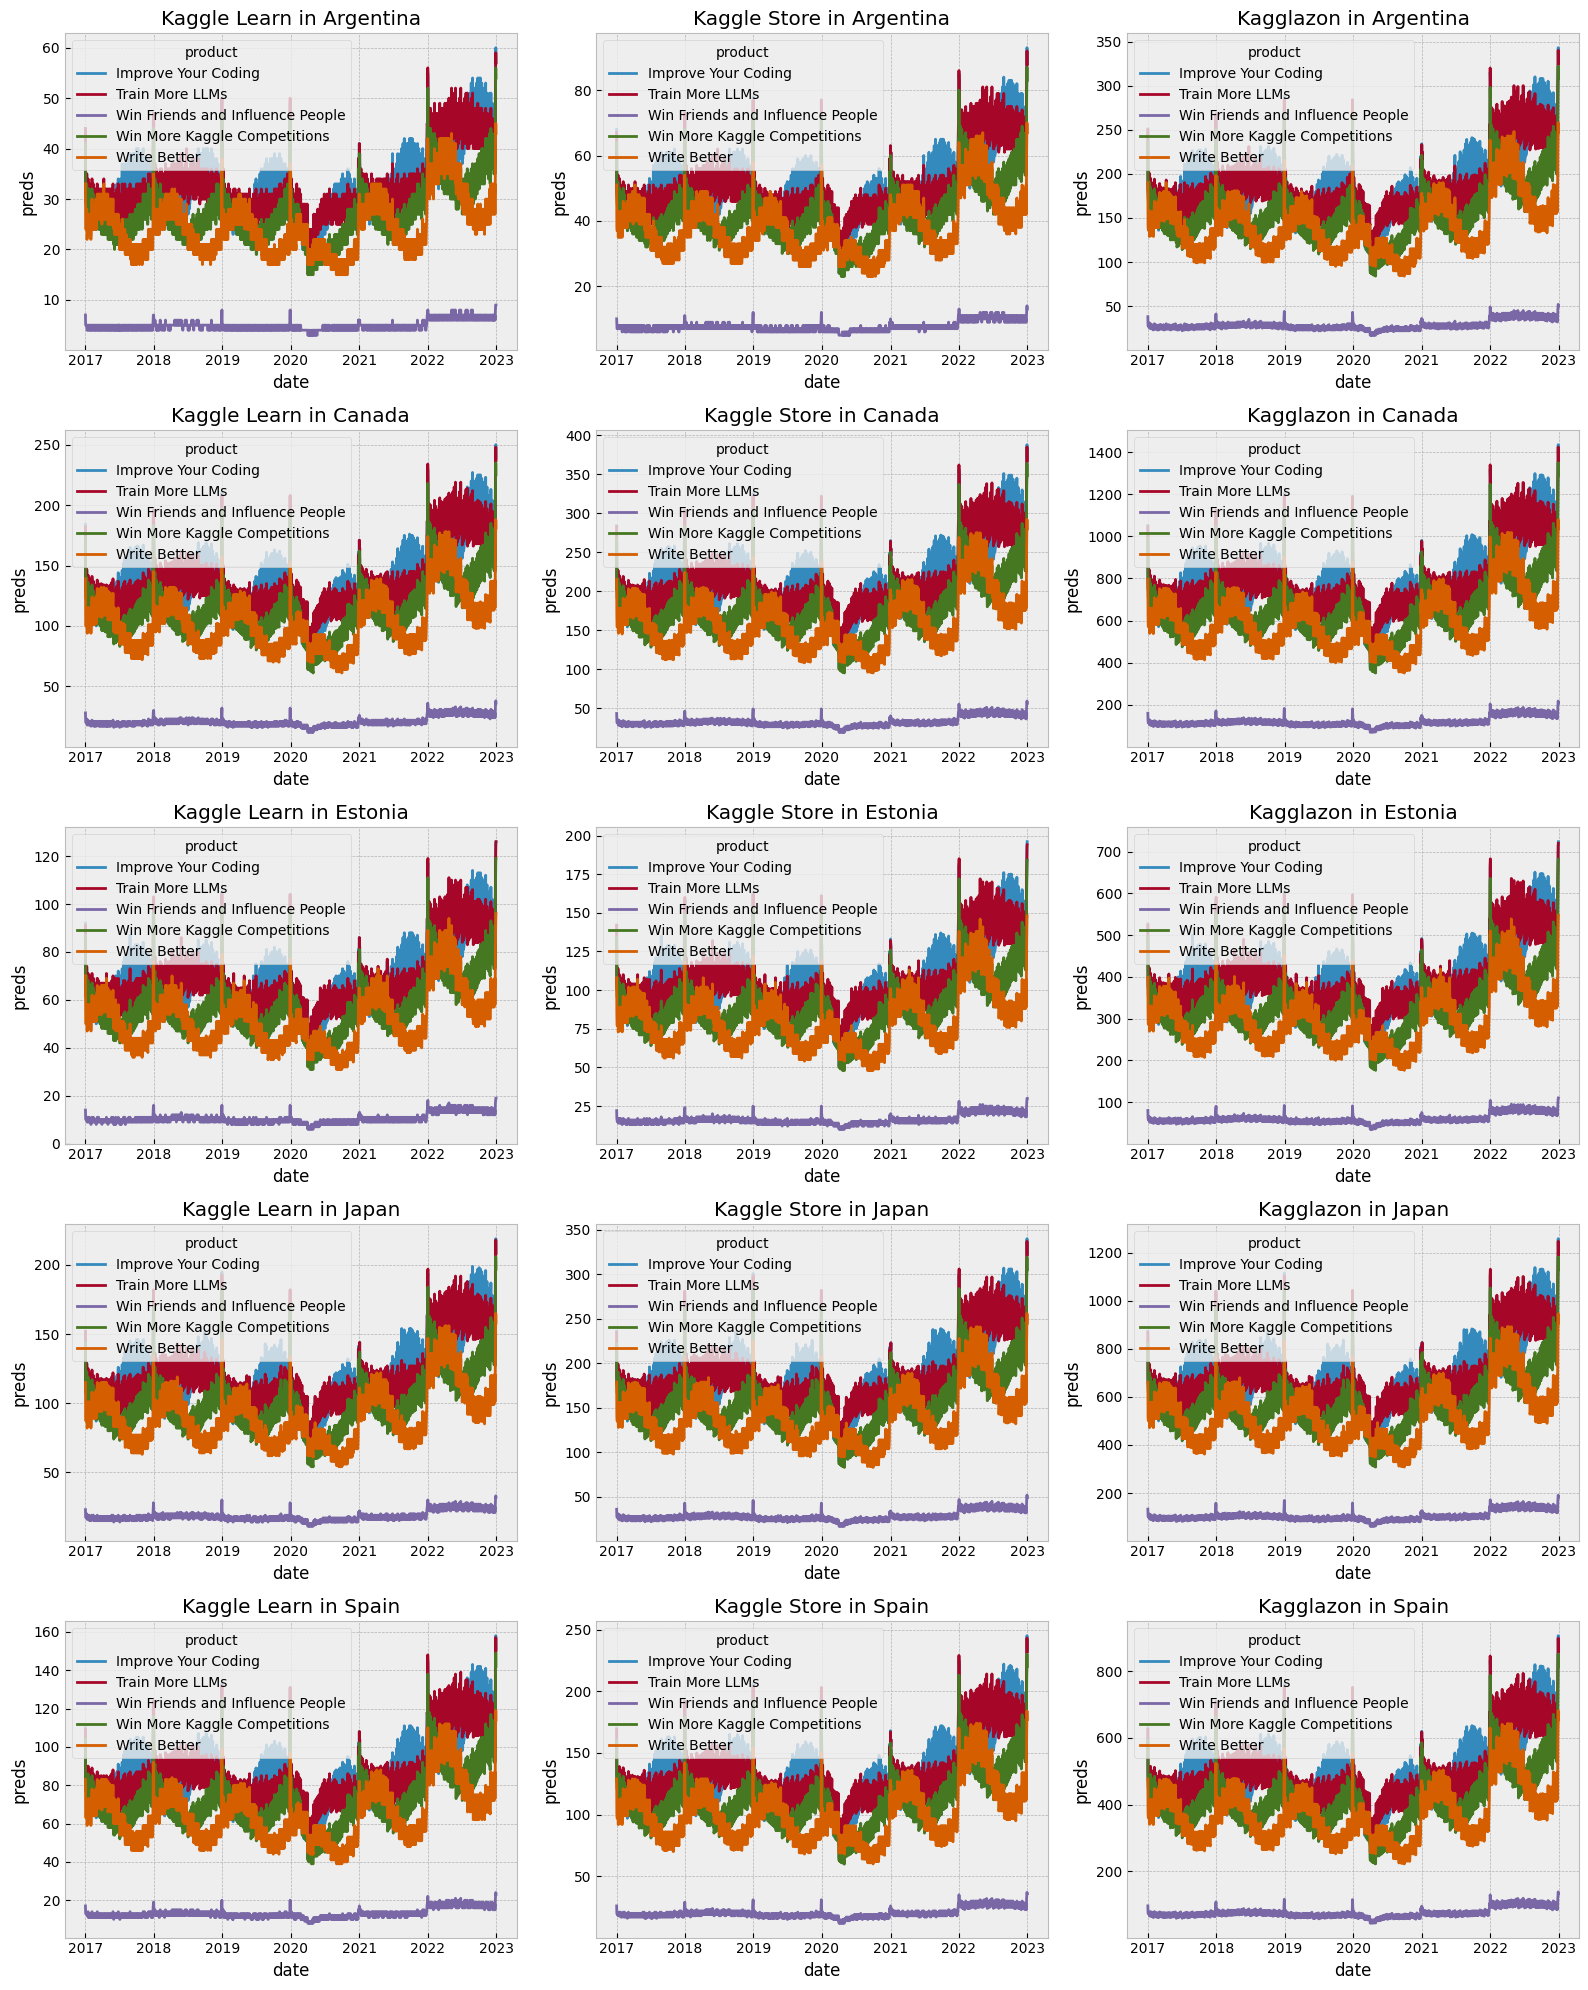

In [22]:
plt.figure(figsize=(16, 20))

df = pd.concat([train, test], axis='rows')
df['preds'] = np.exp(lin_model.predict(scaler.transform(better_extract_features(df)[features]))).round().astype(np.int32)

for i, country in enumerate(COUNTRIES):
    for j, store in enumerate(STORES, 1):
        plt.subplot(len(COUNTRIES), len(STORES), i * len(STORES) + j)

        plt.title(f'{store} in {country}')
        sl = df[(df['country'] == country) & (df['store'] == store)]
        sl['product'] = sl['product'].str.removeprefix('Using LLMs to ')
        sns.lineplot(data=sl, x='date', y='preds', hue='product')

plt.tight_layout()
plt.show()